- The orginal version is https://www.kaggle.com/code/arlle26/s3e26-gb-lgbm-xgb-optuna-vote, which comparing multiple models and using Optuna to tune the model
- In this notebook:
    - Remove the tuning code 
    - improve the feature engineering part (Using One-hot on 'Edema' columns) 
    - update the best_params for xgb&lgb model

Other notebooks used:
- https://www.kaggle.com/code/markuslill/s3e26-xgbclassifer-lgbmclassifier
- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier, log_evaluation, early_stopping
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import AdaBoostRegressor, VotingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from tqdm import tqdm
from colorama import Fore, Back, Style

from sklearn.metrics import log_loss
pd.set_option('display.max_columns', 500)


# set the style
plt.style.use("Solarize_Light2")

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
train= pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
submission=pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
original = pd.read_csv('../input/cirrhosis-patient-survival-prediction/cirrhosis.csv')

In [3]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">EDA
    
<span style="color: #5D8371;">



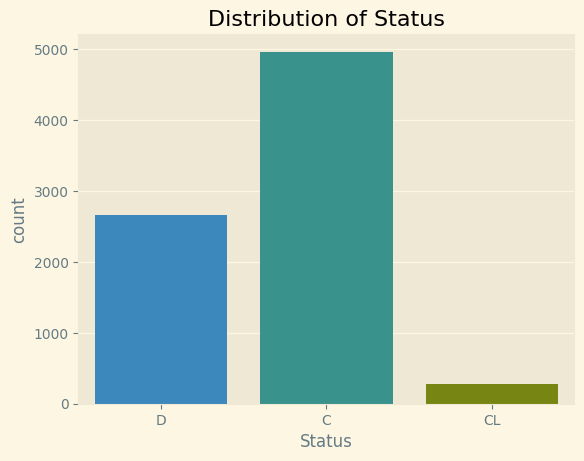

In [4]:
# Distribution of the target variable 'Status'
sns.countplot(x='Status', data=train)
plt.title('Distribution of Status')
plt.show()

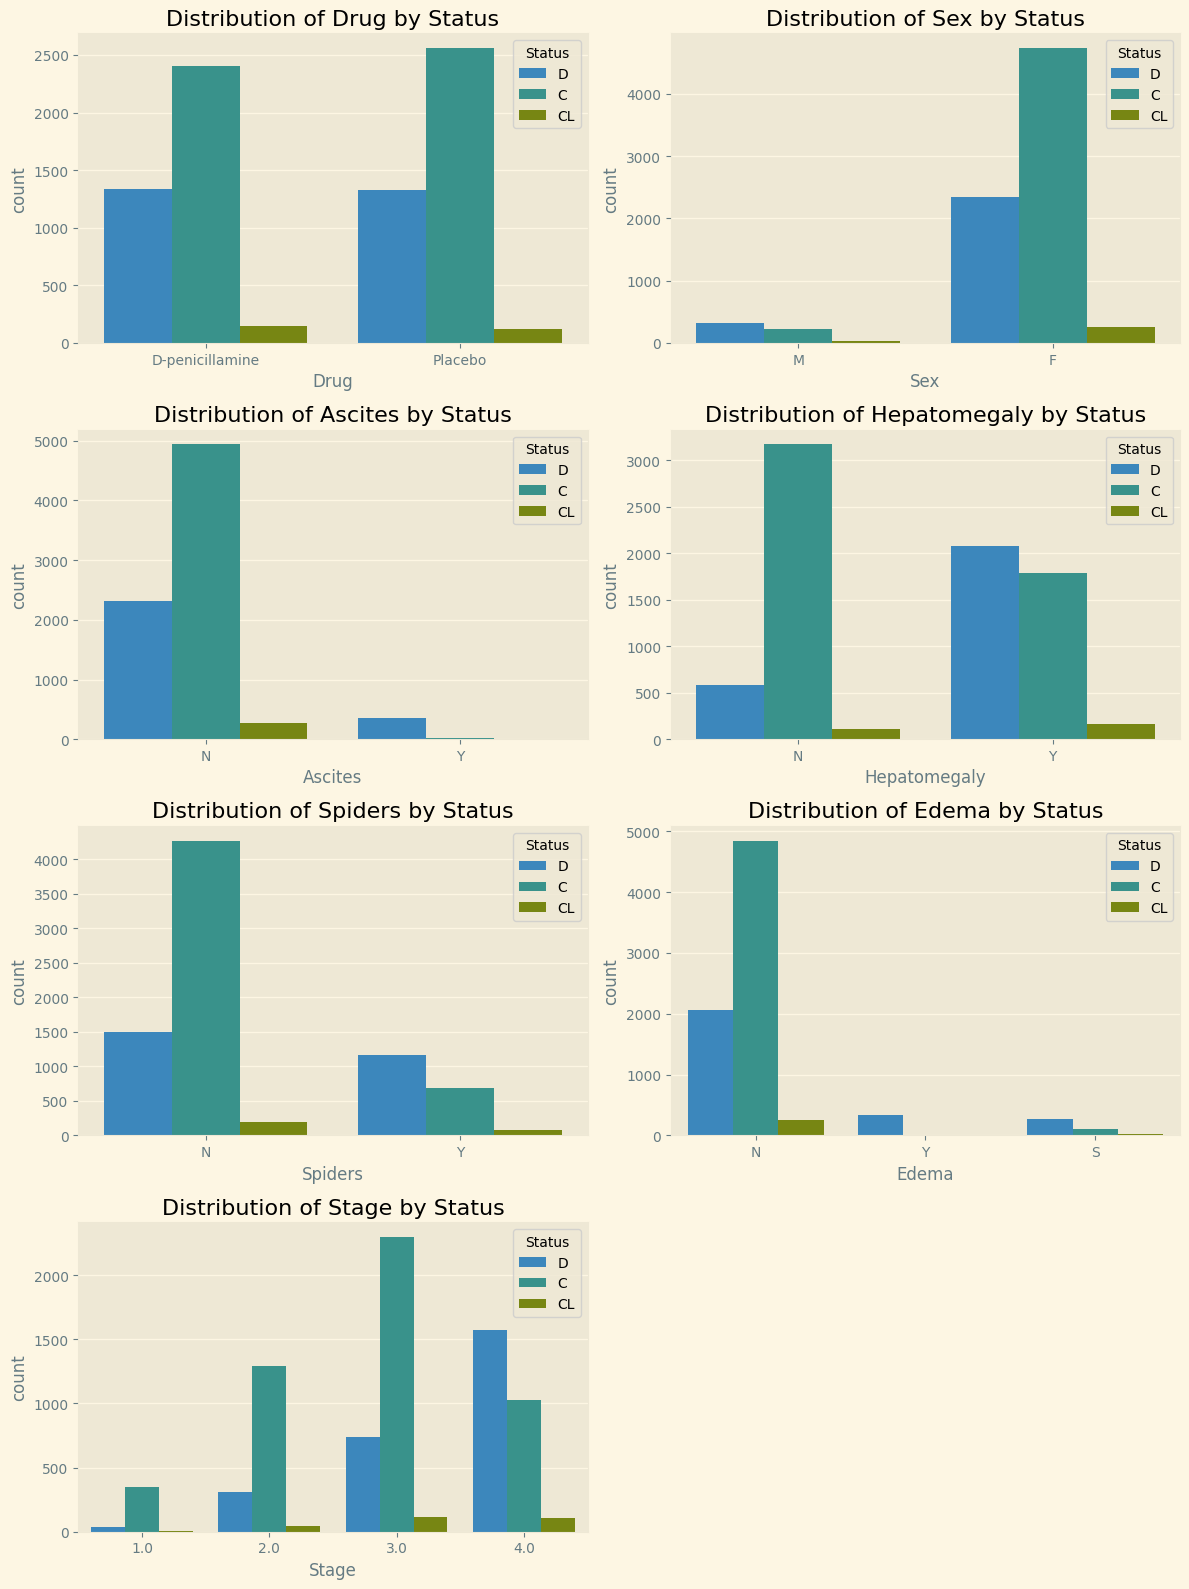

In [5]:
# Distribution of categorical features
categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
rows = (len(categorical_columns) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))

# Flatten the axes array to handle both odd and even numbers of categorical columns
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, hue='Status', data=train, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Status')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [6]:
from matplotlib import colormaps
print(colormaps)

ColormapRegistry; available colormaps:
'magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', 'BuGn_

<Axes: >

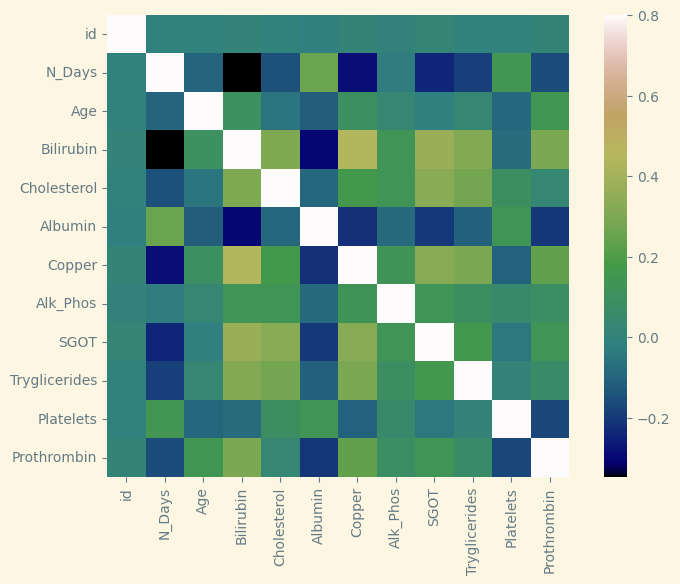

In [7]:
matrix = train.drop(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage','Status'],axis=1).corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=0.8, square=True, cmap='gist_earth')

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">Feature Engineering

<span style="color: #5D8371;">
    
1. **Drop Unnecessary Columns:**
   - Remove unnecessary columns ('id', 'N_Days', 'Status', 'test') from the dataset.

2. **Extract Target:**
   - Set aside the 'Status' column as the target variable to predict.

3. **Encode Categories:**
   - Convert categorical columns ('Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema') into numbers for machine learning.The Label Encoders used for each column are stored in a dictionary called `label_encoders`.

4. **Split Data into Training and Validation Sets:**
   - Divide the data into two sets using `train_test_split`: one for training a machine learning model and another for testing its performance.



In [8]:
train['generated'] = 1
test['generated'] = 1

original = original.drop(columns = 'ID', axis = 1)
original = original.dropna()
original['generated'] = 0

train = pd.concat([train, original], axis = 0).reset_index(drop = True)

In [9]:
# Encode categorical columns
label_encoders = {}
categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema','Status']

for col in categorical_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

# Extract target variable
y = train['Status']

<span style="color: #5D8371;">
    
- Using One-hot on `Edema`

In [10]:
# Select categorical columns
onehot_columns = ['Edema']

# Create OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Apply OneHotEncoder to categorical columns
onehot_encoded = onehot_encoder.fit_transform(train[onehot_columns])

# Create a DataFrame with the one-hot encoded features
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_columns))

# Replace the original categorical columns with one-hot encoded columns
train = pd.concat([train, onehot_df], axis=1)
train = train.drop(onehot_columns, axis=1) # not delete the orginal edma columns which improve LGBM model

In [11]:
# Drop unnecessary columns
X = train.drop(['id',
                #'N_Days',
                'Status'], axis=1)
    

In [12]:
X.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,generated,Edema_0,Edema_1,Edema_2
0,999,0,21532,1,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,1,1.0,0.0,0.0
1,2574,1,19237,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,1,1.0,0.0,0.0
2,3428,1,13727,0,0,1,1,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,1,0.0,0.0,1.0
3,2576,1,18460,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,1,1.0,0.0,0.0
4,788,1,16658,0,0,1,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,1,1.0,0.0,0.0


In [13]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: >

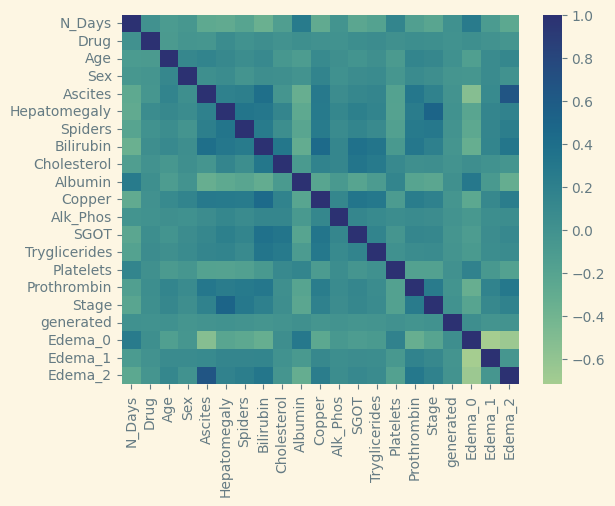

In [14]:
# Create a heatmap all train data
#plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap = 'crest')
#plt.show()

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">Model Comparison
<span style="color: #5D8371;">
    This part allows for a quick comparison of different machine learning models to determine which one performs better based on the log loss metric.



| Model                      | Description                                                                                                                                                                                                                                                                                       |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Random Forest              | Ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes for classification.                                                                                                                                              |
| K-Nearest Neighbors (KNN)  | Instance-based learning algorithm that classifies new instances based on the majority class of their k-nearest neighbors in the training set.                                                                                                                                                     |
| Gradient Boosted Trees     | Ensemble technique that builds trees sequentially, with each tree correcting the errors of the previous one, aiming to create a powerful predictive model.                                                                                                                                      |
| LightGBM                   | Gradient boosting framework that uses tree-based learning algorithms, designed for distributed and efficient training. It is particularly effective with large datasets.                                                                                                                         |
| Support Vector Machine (SVM)| Binary classification algorithm that finds the hyperplane that best separates classes. The version used here can also provide probabilities for class membership.                                                                                                                                |
| Naive Bayes                | Probabilistic classifier based on Bayes' theorem with the "naive" assumption of independence between features. Simple and effective for certain types of datasets.                                                                                                                             |
| Decision Tree              | Tree-like model where an internal node represents a feature, the branch represents a decision rule, and each leaf node represents the outcome.                                                                                                                                                  |
| AdaBoost                   | Adaptive boosting algorithm that combines weak learners into a strong learner, giving more weight to misclassified instances in each iteration to improve overall performance.                         

In [15]:
def fit_and_evaluate(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    model_pred = model.predict_proba(X_val)
    model_loss = log_loss(y_val, model_pred)
    return model_loss

# Define models
models = {
    'XGBClassifier': XGBClassifier(random_state=60),
    #'Random Forest': RandomForestClassifier(random_state=60),
    #'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
    'Gradient Boosted': GradientBoostingClassifier(random_state=60),
    'LGBMClassifier': lgb.LGBMClassifier(),
    #'Support Vector Machine': SVC(probability=True, random_state=60),
    #'Naive Bayes': GaussianNB(),
    #'Decision Tree': DecisionTreeClassifier(random_state=60), 
    #'AdaBoost': AdaBoostClassifier(random_state=60)
}


In [16]:
# Train and evaluate each model
loss_scores = {}
for name, model in models.items():
    score = fit_and_evaluate(model, X_train, y_train, X_val, y_val)
    loss_scores[name] = score
    
    
# check the result
loss_scores

{'XGBClassifier': 0.4955326681208041,
 'Gradient Boosted': 0.44103066169920246,
 'LGBMClassifier': 0.45735699691880416}

default model log loss:
```{'XGBClassifier': 0.5124671581528468,
'Random Forest': 0.4925797309973754,
'K-Nearest Neighbors': 1.7878223897472159,
'Gradient Boosted': 0.4551029605070778,
'LGBMClassifier': 0.4734207807756633,
'Support Vector Machine': 0.7347922958254944,
'Naive Bayes': 1.5515366762451375,
'AdaBoost': 1.0540560282040303}


In [17]:
# Create a dataframe to hold the results
model_comparison = pd.DataFrame({'model': list(models.keys()), 'logloss': list(loss_scores.values())})

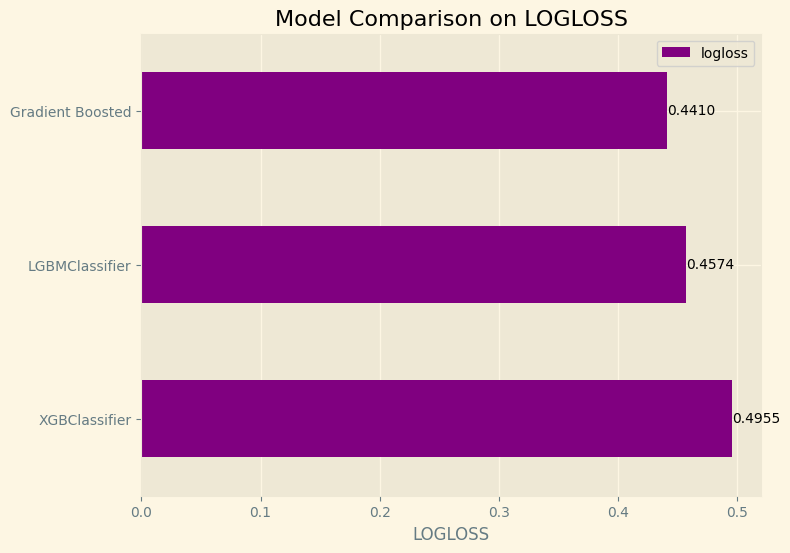

In [18]:
# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
model_comparison.sort_values('logloss', ascending=False).plot.barh(x='model', y='logloss', ax=ax, color='purple')
ax.set_ylabel('')
ax.set_xlabel('LOGLOSS')
for index, value in enumerate(model_comparison.sort_values('logloss', ascending=False)['logloss']):
    ax.text(value, index, f'{value:.4f}', ha='left', va='center')
ax.set_title('Model Comparison on LOGLOSS')
plt.show()

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">GradientBoostingClassifier
<span style="color: #5D8371;">

In [19]:
#copy the best model params from GridSearchCV
best_gb_model = GradientBoostingClassifier(loss='log_loss', 
                                             learning_rate=0.1, 
                                             max_depth=3, 
                                             min_samples_leaf=4, 
                                             min_samples_split=2, 
                                             n_estimators=300, 
                                             subsample=0.8,
                                             random_state=60)

best_gb_model.fit(X_train, y_train)
best_gb_model_pred = best_gb_model.predict_proba(X_val)
best_gb_model_loss = log_loss(y_val, best_gb_model_pred)

best_gb_model_loss 

0.4263875615410395

In [20]:
best_model=best_gb_model

In [21]:
# Make predictions on the validation set
y_pred = best_model.predict_proba(X_val)

# Evaluate the best model
gb_best_model_loss = log_loss(y_val, y_pred)
#print(f'Best Model Parameters: {best_params}')
print(f'Log Loss on Validation Set: {gb_best_model_loss}')

Log Loss on Validation Set: 0.4263875615410395


In [22]:
gb_classifier=best_model

## <span style="color: #5D8371;">Feature Importance

<Axes: >

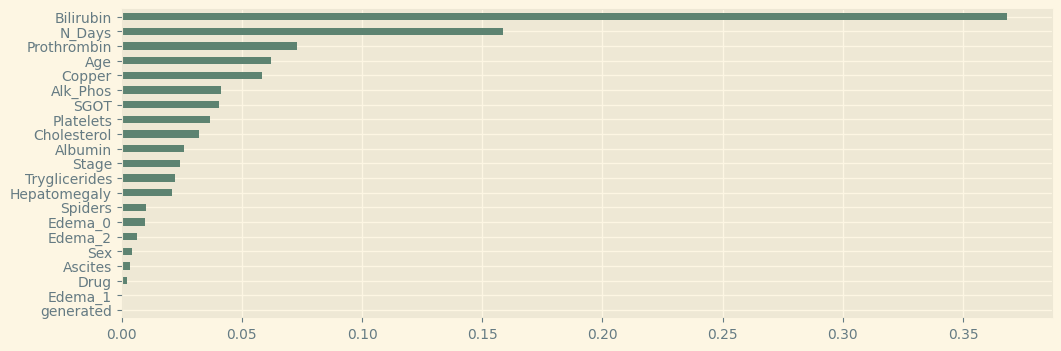

In [23]:
importances=pd.Series(best_model.feature_importances_, index=X.columns) 
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', figsize=(12,4), color='#5D8371')

## <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">LGBM 
<span style="color: #5D8371;"> Same as above, we create a baseline model first, Then using `optuna` to tuning the model

In [24]:
# set params: https://www.kaggle.com/code/markuslill/s3e26-xgbclassifer-lgbmclassifier
best_params={'objective': 'multi_logloss',
             'max_depth': 8,
             'min_child_samples': 16,
             'learning_rate': 0.014553931721109505,
             'n_estimators': 779,
             'min_child_weight': 9,
             'subsample': 0.44799071313755495
             , 'colsample_bytree': 0.15868021337418978,
             'reg_alpha': 0.17992542471160344,
             'reg_lambda': 0.8231621177994548,
             'random_state': 60}

In [25]:
# Train the model with the best hyperparameters
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = best_model.predict_proba(X_val)

# Evaluate the best model
lgb_best_model_loss = log_loss(y_val, y_pred)
print(f'Best Model Log Loss: {lgb_best_model_loss}')

Best Model Log Loss: 0.4139317794457509


In [26]:
lgbm_classifier=best_model

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">XGBClassifier
<span style="color: #5D8371;">

In [27]:
best_params = {'objective': 'multi_logloss',
              #'early_stopping_rounds': 50,
              'max_depth': 9,
              'min_child_weight': 8,
              'learning_rate': 0.034,
              'n_estimators': 733,
              'subsample': 0.693,
              'colsample_bytree': 0.1234702658812108,
              'reg_alpha': 0.18561628377665318,
              'reg_lambda': 0.5565488299127089,
              'random_state':60}

In [28]:
# Train the model with the best hyperparameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = best_model.predict_proba(X_val)

# Evaluate the best model
xgb_best_model_loss = log_loss(y_val, y_pred)
print(f'Best Model Log Loss: {xgb_best_model_loss}')

Best Model Log Loss: 0.4119421986061599


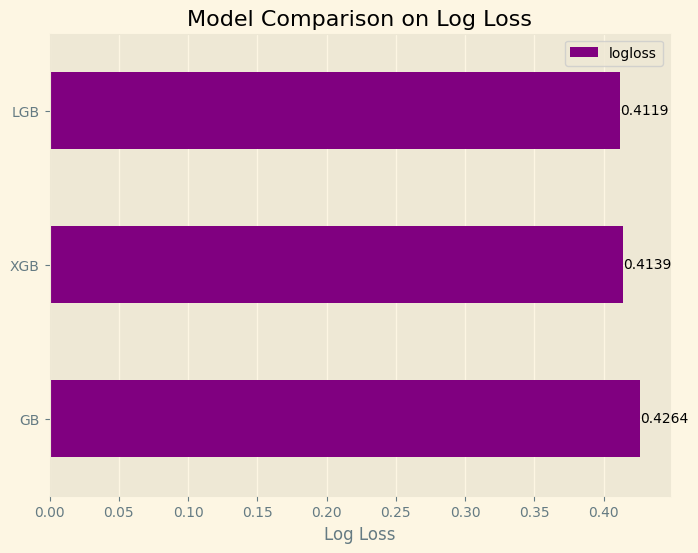

In [29]:
# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
model_comparison = pd.DataFrame({'model': ['GB', 'XGB','LGB'], 
                                  'logloss': [gb_best_model_loss,lgb_best_model_loss,xgb_best_model_loss]})
model_comparison.sort_values('logloss', ascending=False).plot.barh(x='model', y='logloss', ax=ax,  color='purple')
ax.set_ylabel('')
ax.set_xlabel('Log Loss')
ax.set_title('Model Comparison on Log Loss')
for index, value in enumerate(model_comparison.sort_values('logloss', ascending=False)['logloss']):
    ax.text(value, index, f'{value:.4f}', ha='left', va='center')
plt.show()


In [30]:
xgb_classifier=best_model

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">Ensemble Learning: VoteClassifier
<span style="color: #5D8371;">


The `VotingClassifier` is a cool tool in machine learning that combines the predictions from several models to make better predictions together. 
- It's like having a team of experts voting on the best answer. 
- The `VotingClassifier` works for both classification and regression problems, 
- It has different voting styles：
    - In 'hard' voting, it picks the most popular choice among the models, 
    - while in 'soft' voting, it considers the confidence of each model. 

In [31]:
# List of weight combinations to test
weight_combinations = [
    (1, 1, 1),  # Equal weights
    (2, 1, 1),  # Double weight for the first classifier
    (1, 2, 1),  # Double weight for the second classifier
    (1, 1, 2),  # Double weight for the third classifier
    # Add more combinations as needed
]

for weights in weight_combinations:
    # Create a voting classifier with the current set of weights
    vote_classifier = VotingClassifier(
        estimators=[
            ('gradient_boosted', gb_classifier),
            ('XGB', xgb_classifier),
            ('lgbm', lgbm_classifier)
        ],
        voting='soft',  # Use 'hard' for majority voting or 'soft' for weighted voting based on class probabilities
        weights=weights
    )

    # Fit the voting classifier on the training data
    vote_classifier.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = vote_classifier.predict_proba(X_val)

    # Evaluate the log loss of the ensemble model
    accuracy = log_loss(y_val, y_pred)
    print(f'Weights: {weights}, Ensemble Model Accuracy: {accuracy:.8f}')

Weights: (1, 1, 1), Ensemble Model Accuracy: 0.40899112
Weights: (2, 1, 1), Ensemble Model Accuracy: 0.41068910
Weights: (1, 2, 1), Ensemble Model Accuracy: 0.40819532
Weights: (1, 1, 2), Ensemble Model Accuracy: 0.40951872


select the lowest combination of [1,1,2]

In [32]:
# Create a voting classifier
vote_classifier = VotingClassifier(
    estimators=[
        ('gradient_boosted', gb_classifier),
         ('XGB', xgb_classifier),
        ('lgbm', lgbm_classifier)
    ],
    voting='soft',  # Use 'hard' for majority voting or 'soft' for weighted voting based on class probabilities
    weights=[1, 2, 1] 
)

# Fit the voting classifier on the training data
vote_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = vote_classifier.predict_proba(X_val)

# Evaluate the accuracy of the ensemble model
accuracy = log_loss(y_val, y_pred)
print(f'Ensemble Model Accuracy: {accuracy:.8f}')


Ensemble Model Accuracy: 0.40819532


# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Roboto;text-align:left;display:fill;border-radius:5px;background-color:green;overflow:hidden">Prediction
<span style="color: #5D8371;">

In [33]:
#select the model
model=vote_classifier

In [34]:
test_data = test.drop(['id'], axis=1)

exclude_keys = ['Status']

# Encode categorical columns in the test set using the same LabelEncoders
for col, le in label_encoders.items():
    if col not in exclude_keys:
        test_data[col] = le.transform(test_data[col])
        
        
# ONEHOT
onehot_encoded = onehot_encoder.fit_transform(test_data[onehot_columns])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_columns))
test_data = pd.concat([test_data, onehot_df], axis=1)
test_data = test_data.drop(onehot_columns, axis=1)

In [35]:
# Make predictions on the test set
test_predictions = model.predict_proba(test_data)

# Create a DataFrame for the submission file
submission_df = pd.DataFrame({
    'id': test['id'],
    'Status_C': test_predictions[:, 0],
    'Status_CL': test_predictions[:, 1],
    'Status_D': test_predictions[:, 2]
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)